# Project work for *02901 Advanced Topics in Machine Learning: Computational Tools for Machine Learning in Python*

We will in this notebook present a reanalysis of the MA2 process example in *Learning Summary Statistic for Approximate Bayesian Computation via Deep Neural Network* [link to paper](https://www.researchgate.net/publication/282691910_Learning_Summary_Statistic_for_Approximate_Bayesian_Computation_via_Deep_Neural_Network). 

For building and training the deep neural networks we use th `PyTorch` package. We also use `Numpy` and some functions from `Statsmodels` and `math` for the implementation of the ABC rejection sampling algorithm. `Matplotlib` is used for plotting.

### Setup

Load packages 

In [1]:
%matplotlib inline

import torch
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stats
import math


Set ground-truth parameters and load data. 

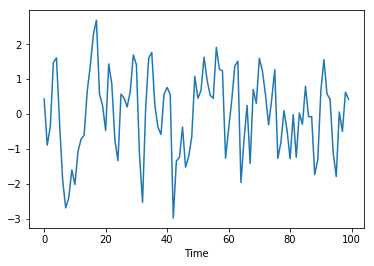

In [2]:
θ_true = np.array([0.6, 0.2]) # ground-truth parameter values 

ma2_data = np.genfromtxt('data/ma2_data.csv', delimiter=',') # load data 
obs_nbrs = ma2_data[1:101,0]
y_obs = ma2_data[1:101,1]

# plot datbba 
plt.plot(y_obs); 
plt.xlabel("Time");


### Train Network 

Load training, validation, and test data. 

In [3]:
# load data from file 
X_training = np.genfromtxt("data/X_training.csv",delimiter=',')
X_val = np.genfromtxt("data/X_val.csv",delimiter=',')
X_test = np.genfromtxt("data/X_test.csv",delimiter=',')

y_training = np.genfromtxt("data/y_training.csv",delimiter=',')
y_val = np.genfromtxt("data/y_val.csv",delimiter=',')
y_test = np.genfromtxt("data/y_test.csv",delimiter=',')

# remove empty row 
X_training = X_training[1:500000,:]
X_val = X_val[1:100,:]
X_test = X_test[1:len(X_training),:]

y_training = y_training[1:500000,:]
y_val = y_val[1:100,:]
y_test = y_test[1:len(y_test),:]

# transpose input data 
X_training = np.transpose(X_training)
X_val = np.transpose(X_val)
X_test = np.transpose(X_test)

# convert to torch
X_training = torch.from_numpy(X_training)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)

y_training = torch.from_numpy(y_training)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

Set up network 

In [4]:
model = torch.nn.Sequential(torch.nn.Linear(100, 100), torch.nn.ReLU(), torch.nn.Linear(100, 100),torch.nn.ReLU(), torch.nn.Linear(100, 50), torch.nn.ReLU(), torch.nn.Linear(50, 2)).double() 
optimizer  =  torch.optim.Adam(model.parameters())
loss_func = torch.nn.MSELoss()

Train network 

In [5]:
save_model = False # save trained model 
load_model = True # set to false to retrain the model 

if not load_model:
    
    nbr_obs = y_training.shape[0]
    nbr_epoch = 10

    idx = range(nbr_obs)
    loss_eval_vec = torch.zeros(nbr_epoch)
    loss_training_vec = torch.zeros(nbr_epoch)

    for epoch in range(1,nbr_epoch+1): 

        print('Epoch:', epoch)
        loss_training = 0
        loss_eval = 0 

        # calc loss at current epoch for evaluation data and part of training data     
        for obs in range(0,y_val.shape[0]): 

            with torch.no_grad():
                pred = model(X_val[:,obs])
                loss_eval = loss_eval+loss_func(pred, y_val[obs,:]) 
                idx_training = np.random.choice(idx, 1)[0] # get one obs. from training data at random  
                pred = model(X_training[:,idx_training])
                loss_training = loss_training+loss_func(pred, y_training[idx_training,:])              

        loss_eval_vec[epoch-1] = loss_eval/y_val.shape[0]
        loss_training_vec[epoch-1] = loss_training/y_val.shape[0]

        print('Training loss:', loss_eval_vec[epoch-1])
        print('Eval. loss:', loss_training_vec[epoch-1])

        # train on entier trainin data set     
        for obs in range(0,y_training.shape[0]): 

            pred = model(X_training[:,obs])
            loss = loss_func(pred, y_training[obs,:])  
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()

    if save_model: 
        torch.save(model, 'model.pt')
        torch.save(loss_eval_vec, 'loss_eval_vec.pt')
        torch.save(loss_training_vec, 'loss_training_vec.pt')
else:
    model = torch.load('model.pt')
    loss_eval_vec = torch.load('loss_eval_vec.pt')
    loss_training_vec = torch.load('loss_training_vec.pt')

Plot loss 

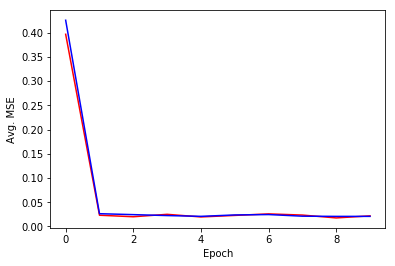

In [6]:
plt.plot(loss_training_vec.numpy(), "r")
plt.plot(loss_eval_vec.numpy(), "b")
plt.xlabel("Epoch")
plt.ylabel("Avg. MSE");

Test network 

In [7]:
nbr_obs = y_test.shape[0]
loss_test = torch.zeros(nbr_obs)
predictions = torch.zeros(nbr_obs,2)

with torch.no_grad():
    for i in range(0,nbr_obs):
        pred = model(X_test[:,i])
        predictions[i,:] = pred
        loss_test[i] = loss_func(pred, y_test[i,:])
        
loss_test = loss_test.numpy()
predictions = predictions.numpy()
y_test = y_test.numpy()


print("Avg. MSE")
print(np.mean(loss_test))

Avg. MSE
0.021323057


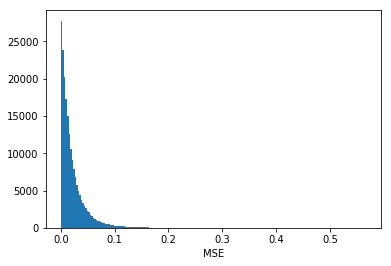

In [8]:
plt.hist(loss_test,200)
plt.xlabel("MSE");

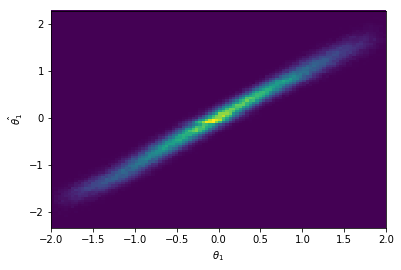

In [9]:
plt.hist2d(y_test[:,0],predictions[:,0],100);
plt.ylabel("$\hat{θ_1}$");
plt.xlabel("$θ_1$");

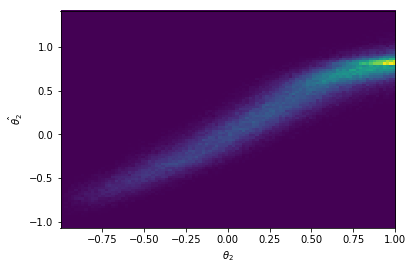

In [10]:
plt.hist2d(y_test[:,1],predictions[:,1],100);
plt.ylabel("$\hat{θ_2}$");
plt.xlabel("$θ_2$");

### Run ABC inference 

Functions defining the MA2 process. 

In [11]:
# Sample from the Uniform prior distribution
def sample_from_prior():
    while True:
        θ_1 = np.random.uniform(-2, 2)
        θ_2 = np.random.uniform(-1, 1) 
        if θ_2 + θ_1  >= -1 and θ_2 - θ_1 >= -1:
            return np.array([θ_1, θ_2])
    
    
# Evaluate prior distribtuion
def evaluate_prior(Θ):
    θ_1 = Θ[0]
    θ_2 = Θ[1]
    if abs(θ_1) <= 2 and abs(θ_2) <= 1 and θ_2 + θ_1 >= -1 and θ_2 - θ_1 >= -1:
        return True
    else:
        return False


# Generate data from the model
def generate_data(Θ):
    
    N_data=100
    θ_1 = Θ[0]
    θ_2 = Θ[1]
    y = np.zeros(N_data)

    if evaluate_prior(Θ):
        ϵ = np.random.normal(0,1,N_data)
        y[0] = ϵ[0]
        y[1] = ϵ[1] + θ_1*y[0]
        for i in  range(2,N_data):
            y[i] = ϵ[i] + θ_1*ϵ[i-1] + θ_2*ϵ[i-2]
    else:
        y[:] = np.nan
    return y

Set function to compute summary statistics

In [12]:
def calc_summary_DNN(y_sim): 
    return model(torch.from_numpy(y_sim)).detach().numpy()

def calc_summary_summary_stats(y_sim): 
    return stats.acovf(y_sim)[0:2]


Define ABC-RS algorithm 

In [13]:
def abcrs(y_obs, proposalas, datasets, calc_summary):

    cutoff_percentile = 0.1 
    
    print("Starting abc-rs")

    N = proposalas.shape[0]
    dist_vector = np.zeros(N)
    s = calc_summary(y_obs)

    for i in range(0,N):
        if i % 50000 == 0: 
            print('"Percentage done:', round(i/N*100,2))
        s_star = calc_summary(datasets[i,:])
        dist_vector[i] = euclidean_dist(s, s_star)

    dist_val_cutoff = np.percentile(dist_vector, cutoff_percentile)

    idx_keep = dist_vector <= dist_val_cutoff
    proposalas = proposalas[idx_keep,:]
    
    print("Ending abc-rs")

    return proposalas


def euclidean_dist(s_star, s):
    return math.sqrt(sum(np.power(s_star-s,2)))

load the parameter data pairs for the ABC-RS algorithm 

In [14]:
# load data from file 
proposalas = np.genfromtxt("data/abc_data_parameters.csv",delimiter=',')
datasets = np.genfromtxt("data/abc_data_data.csv",delimiter=',')

# remove empty row 
proposalas = proposalas[1:len(proposalas),:]
datasets = datasets[1:len(datasets),:]


Run ABC-RS using summary statisitics 

In [15]:
approx_posterior_abc_summary_stats = abcrs(y_obs, proposalas, datasets, calc_summary_summary_stats)

Starting abc-rs
"Percentage done: 0.0
"Percentage done: 10.0
"Percentage done: 20.0
"Percentage done: 30.0
"Percentage done: 40.0
"Percentage done: 50.0
"Percentage done: 60.0
"Percentage done: 70.0
"Percentage done: 80.0
"Percentage done: 90.0
Ending abc-rs


Run ABC-RS using DNN  

In [16]:
approx_posterior_abc_DNN = abcrs(y_obs, proposalas, datasets, calc_summary_DNN)

Starting abc-rs
"Percentage done: 0.0
"Percentage done: 10.0
"Percentage done: 20.0
"Percentage done: 30.0
"Percentage done: 40.0
"Percentage done: 50.0
"Percentage done: 60.0
"Percentage done: 70.0
"Percentage done: 80.0
"Percentage done: 90.0
Ending abc-rs


Plot posterior inference 

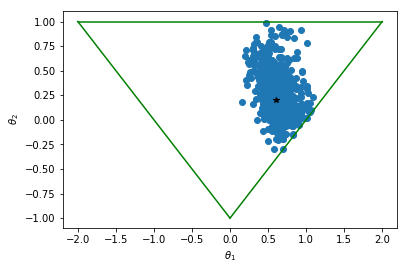

In [17]:
# plot posterior inference for ABC w. summary statistics
plt.plot((0,-2),(-1,1), "g")
plt.plot((-2,2),(1,1), "g")
plt.plot((0,2),(-1,1), "g")
plt.scatter(approx_posterior_abc_summary_stats[:,0],approx_posterior_abc_summary_stats[:,1])
plt.plot(θ_true[0],θ_true[1], "k*")
plt.ylabel("$θ_2$")
plt.xlabel("$θ_1$");

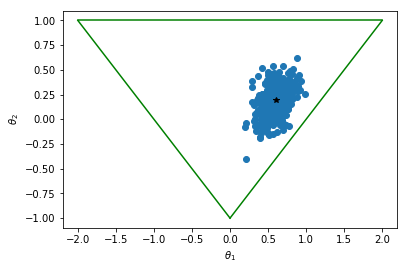

In [18]:
# plot posterior inference for ABC w. DNN statistics 
plt.plot((0,-2),(-1,1), "g")
plt.plot((-2,2),(1,1), "g")
plt.plot((0,2),(-1,1), "g")
plt.scatter(approx_posterior_abc_DNN[:,0],approx_posterior_abc_DNN[:,1])
plt.plot(θ_true[0],θ_true[1], "k*")
plt.ylabel("$θ_2$")
plt.xlabel("$θ_1$");

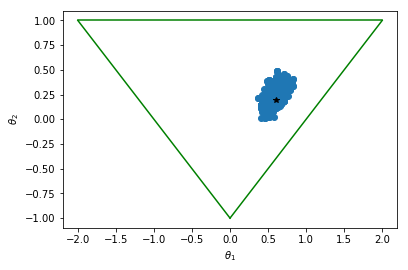

In [19]:
# load exact posterior (computed using MCMC)
posterior_exact = np.genfromtxt("data/exact_mcmc_post.csv",delimiter=',')
posterior_exact = posterior_exact[1:len(posterior_exact),:]

# plot posterior inference for ABC w. DNN statistics 
plt.plot((0,-2),(-1,1), "g")
plt.plot((-2,2),(1,1), "g")
plt.plot((0,2),(-1,1), "g")
plt.scatter(posterior_exact[:,0],posterior_exact[:,1])
plt.plot(θ_true[0],θ_true[1], "k*")
plt.ylabel("$θ_2$")
plt.xlabel("$θ_1$");